<a href="https://colab.research.google.com/github/E-S-P-I-A/HSE/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_2_WineQuality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Практическая 2 — Статистика и визуализация на Wine Quality (красное вино)
**Дисциплина:** Применение ML в кибербезопасности  
**Тема:** Применение статистики в ML и визуализация данных

Этот ноутбук покрывает все шаги из задания: загрузка данных, проверка пропусков, создание бинарной метки качества, поиск и удаление выбросов по IQR, визуализации, корреляции, и подготовка числовых ответов (после удаления выбросов).

> Источник датасета: UCI Wine Quality (red). Можно загрузить локальный архив `wine+quality.zip`, либо скачать csv по ссылке.


In [1]:

# Установка зависимостей (обычно в Colab не требуется, оставлено для воспроизводимости)
%pip -q install pandas numpy matplotlib requests


In [2]:

import io, os, zipfile, requests, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Настройки графиков
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 120


In [3]:

# === Этап 2: Загрузка данных ===
# Вариант A: если в рабочей директории есть архив 'wine+quality.zip' (как в задании) — используем его.
# Вариант B: иначе скачиваем CSV с UCI.

UCI_RED_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

def load_red_from_zip(zip_path="wine+quality.zip"):
    if not os.path.exists(zip_path):
        return None
    with zipfile.ZipFile(zip_path) as z:
        # стандартные имена файлов согласно UCI
        if "winequality-red.csv" in z.namelist():
            with z.open("winequality-red.csv") as f:
                # в датасете разделитель — ';'
                df = pd.read_csv(f, sep=";")
                return df
    return None

def load_red_from_uci():
    r = requests.get(UCI_RED_URL, timeout=30)
    r.raise_for_status()
    return pd.read_csv(io.StringIO(r.text), sep=";")

try:
    df = load_red_from_zip("wine+quality.zip")
    if df is None:
        print("Локальный архив не найден — скачиваем с UCI...")
        df = load_red_from_uci()
    print("Загружено строк:", len(df), "| колонок:", df.shape[1])
except Exception as e:
    raise SystemExit(f"Ошибка загрузки данных: {e}")

# Переименуем столбец качества для удобства
if "quality" not in df.columns:
    raise SystemExit("В данных нет столбца 'quality'")


Загружено строк: 1599 | колонок: 12


In [4]:

# === Этап 3.1: Проверка пропусков ===
na_counts = df.isna().sum().sort_values(ascending=False)
print("Число пропусков по столбцам (ожидаемо все 0):\n")
print(na_counts.to_string())


Число пропусков по столбцам (ожидаемо все 0):

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0


In [5]:

# === Этап 3.2: Бинарная метка качества ===
# "Хорошее" вино: quality >= 6 -> 1, иначе 0
df["is_good"] = (df["quality"] >= 6).astype(int)

print("Баланс классов (до удаления выбросов):")
print(df["is_good"].value_counts().sort_index())


Баланс классов (до удаления выбросов):
is_good
0    744
1    855
Name: count, dtype: int64


In [6]:

# === Этап 3.3: Поиск выбросов по 'quality' через IQR ===
Q1 = df["quality"].quantile(0.25)
Q3 = df["quality"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

mask_outliers = (df["quality"] < lower) | (df["quality"] > upper)
n_outliers = int(mask_outliers.sum())

print(f"Q1={Q1}, Q3={Q3}, IQR={IQR}, нижняя граница={lower}, верхняя граница={upper}")
print("Количество выбросов по 'quality':", n_outliers)

# === Удаление выбросов ===
df_clean = df.loc[~mask_outliers].copy()
print("Размер после удаления выбросов:", df_clean.shape)


Q1=5.0, Q3=6.0, IQR=1.0, нижняя граница=3.5, верхняя граница=7.5
Количество выбросов по 'quality': 28
Размер после удаления выбросов: (1571, 13)


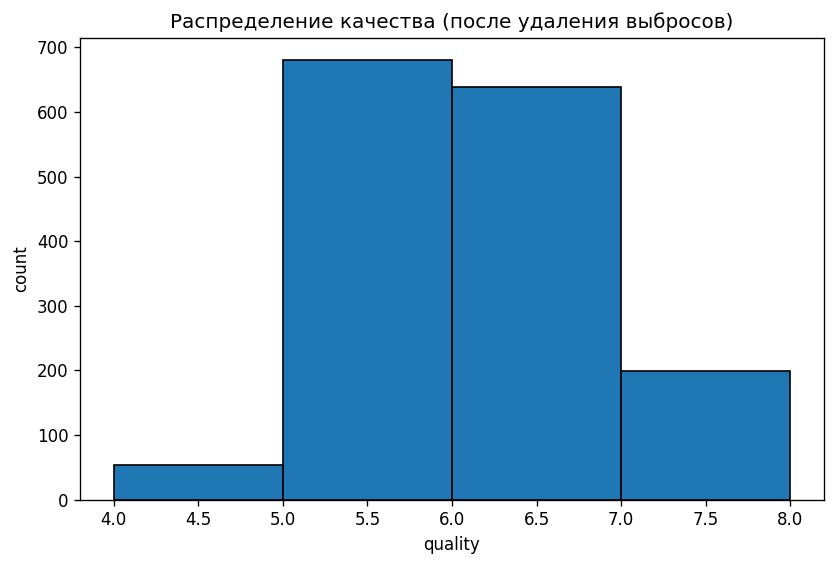

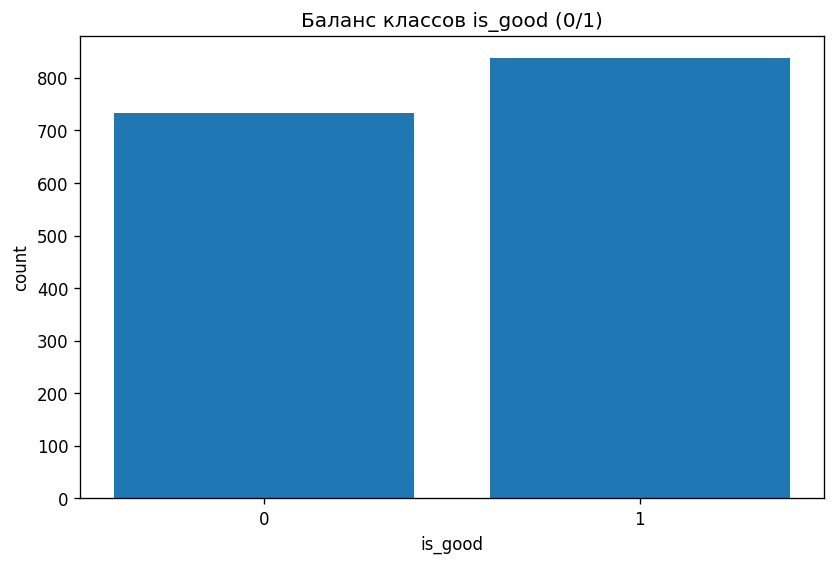

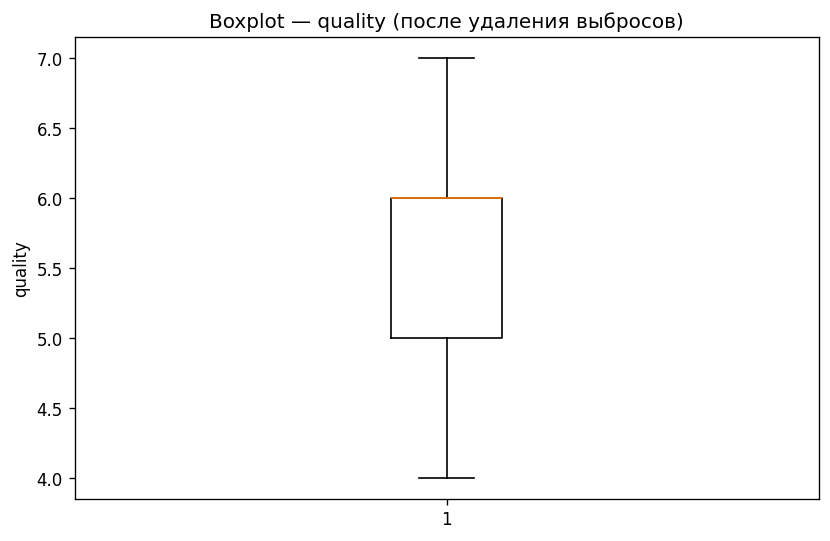

In [7]:

# === Этап 3.4: Визуализации по качеству ===
# 1) Распределение 'quality' (аналог distplot — используем matplotlib.hist)
plt.figure()
plt.hist(df_clean["quality"], bins=range(int(df_clean["quality"].min()), int(df_clean["quality"].max())+2), edgecolor="black")
plt.title("Распределение качества (после удаления выбросов)")
plt.xlabel("quality"); plt.ylabel("count")
plt.show()

# 2) Баланс бинарных классов
plt.figure()
class_counts = df_clean["is_good"].value_counts().sort_index()
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Баланс классов is_good (0/1)")
plt.xlabel("is_good"); plt.ylabel("count")
plt.show()

# 3) Ящик с усами по показателю качества
plt.figure()
plt.boxplot(df_clean["quality"], vert=True)
plt.title("Boxplot — quality (после удаления выбросов)")
plt.ylabel("quality")
plt.show()


In [8]:

# === Этап 3.5: Медианы по каждому признаку (после удаления выбросов) ===
# Исключим бинарную метку и сам 'quality' если нужно отдельно анализировать
feature_cols = [c for c in df_clean.columns if c not in ("is_good",)]
medians = df_clean[feature_cols].median().to_frame(name="median").sort_index()
medians


,median
alcohol,10.10000
chlorides,0.07900
citric acid,0.26000
density,0.99675
fixed acidity,7.90000
free sulfur dioxide,14.00000
pH,3.31000
quality,6.00000
residual sugar,2.20000
sulphates,0.62000


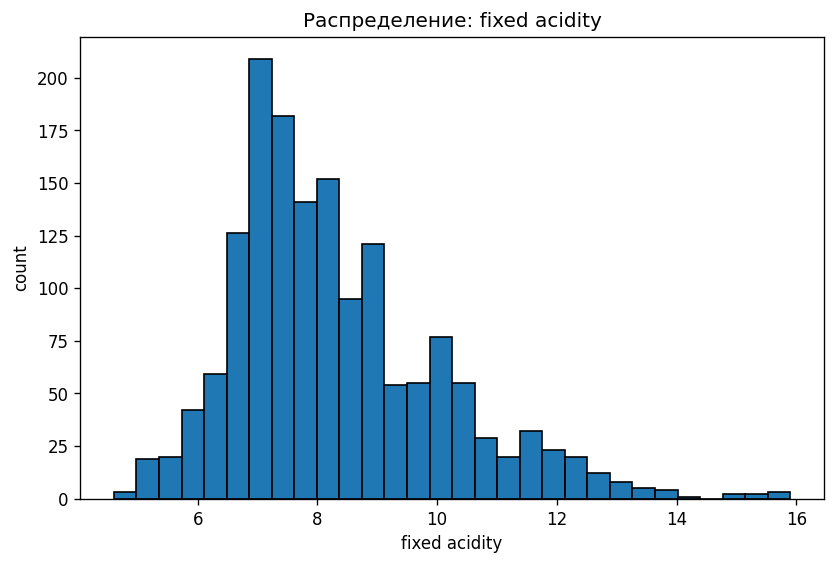

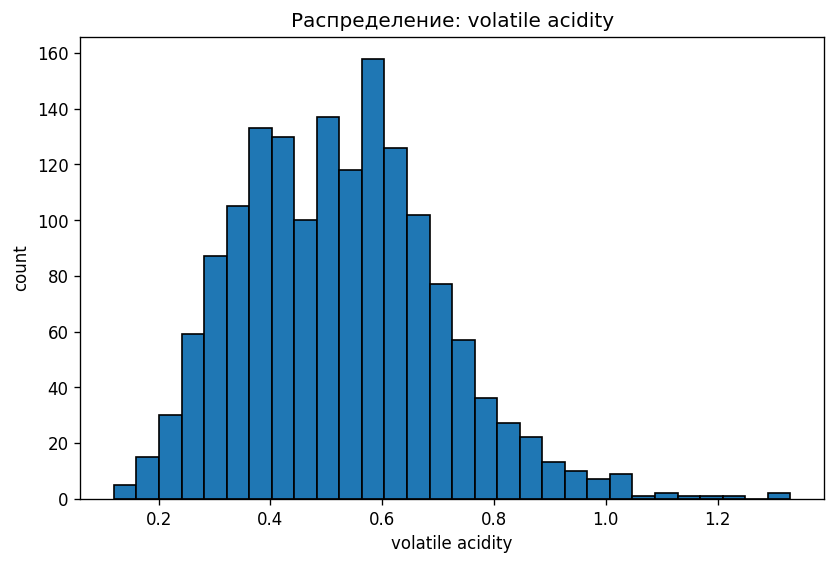

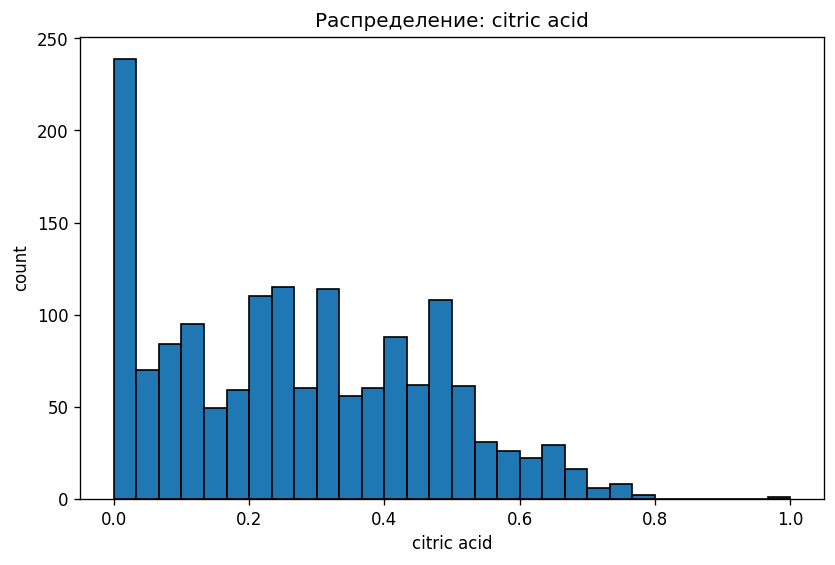

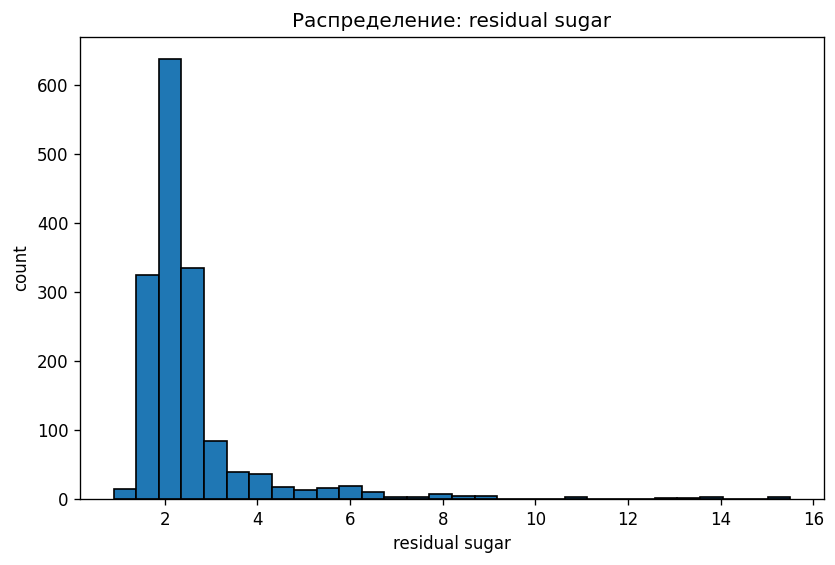

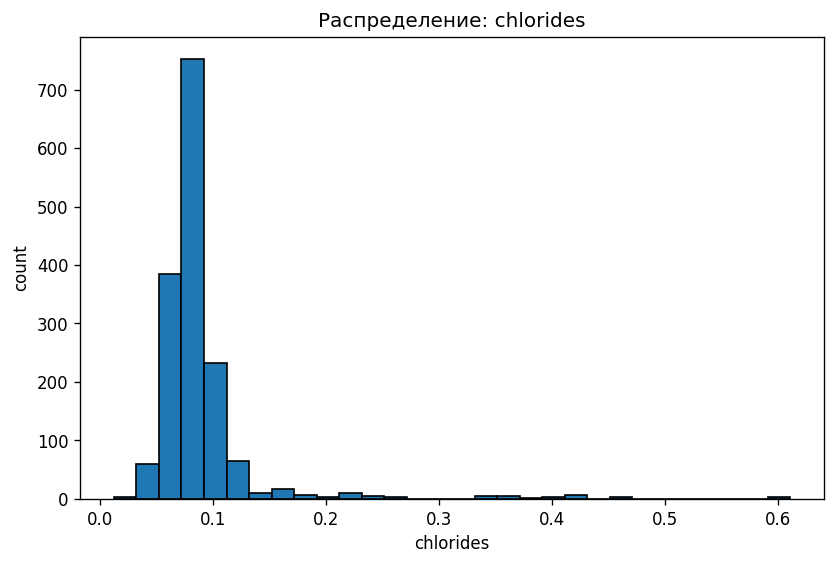

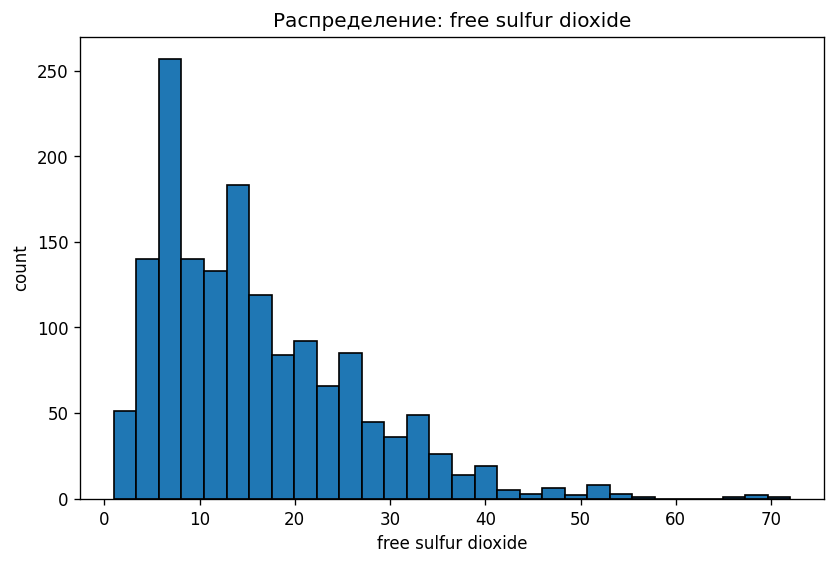

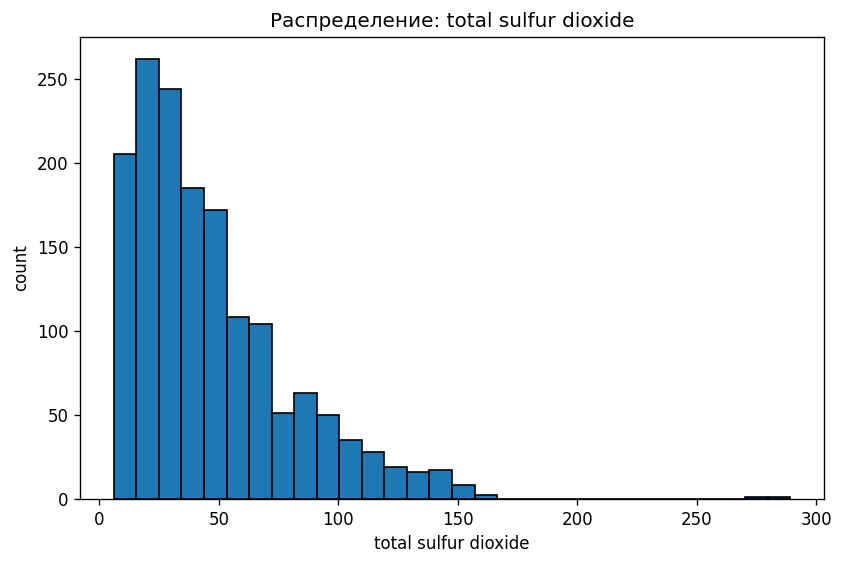

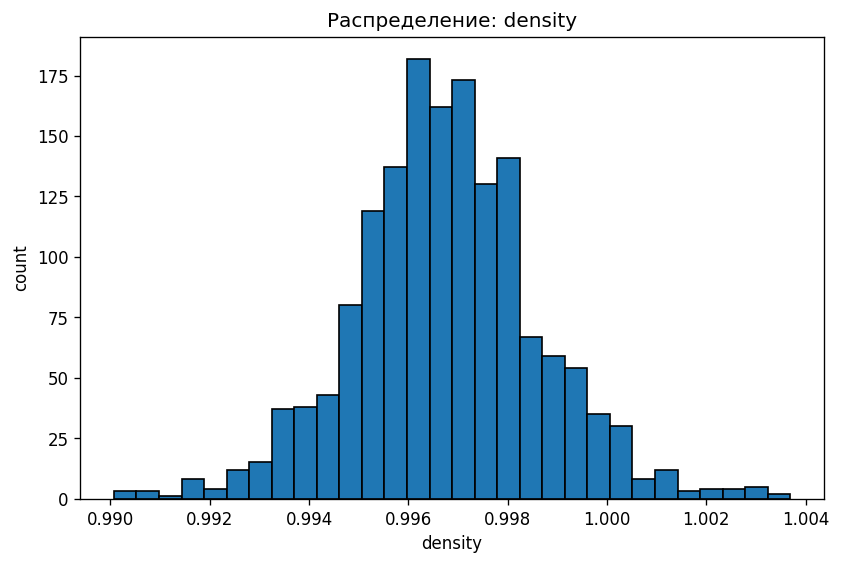

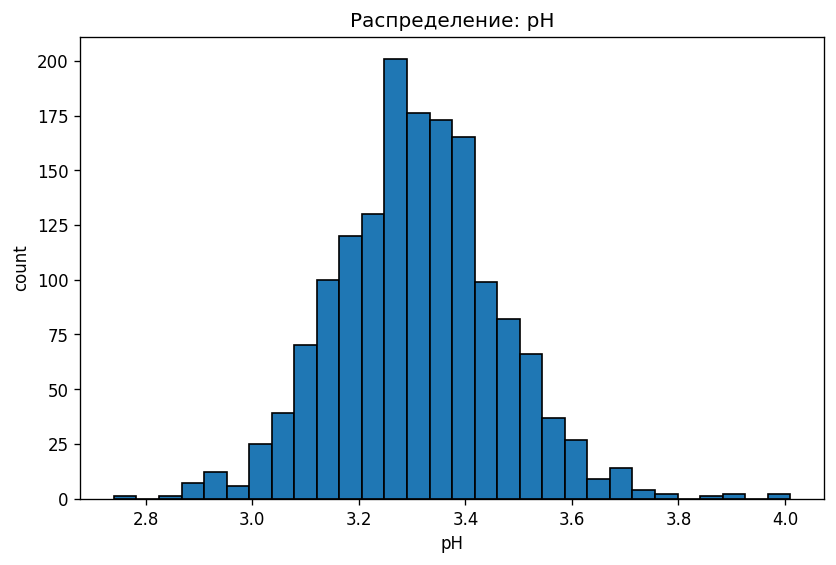

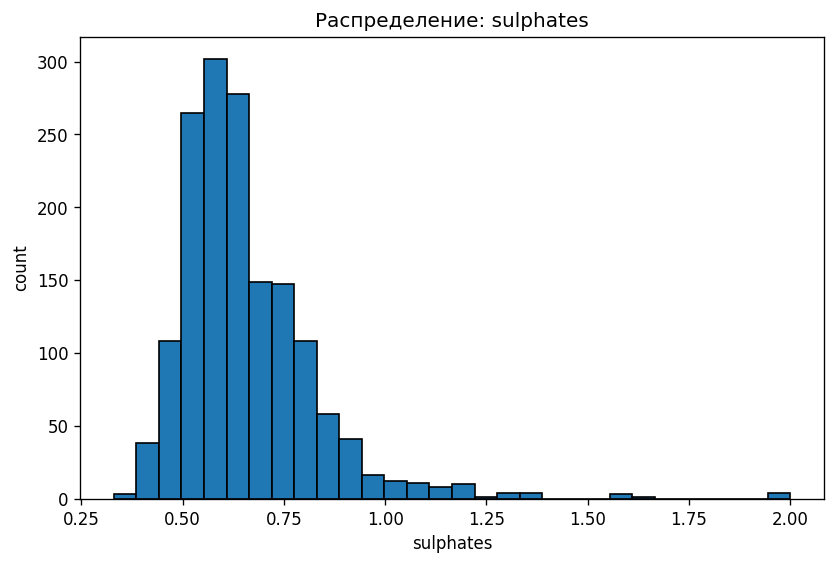

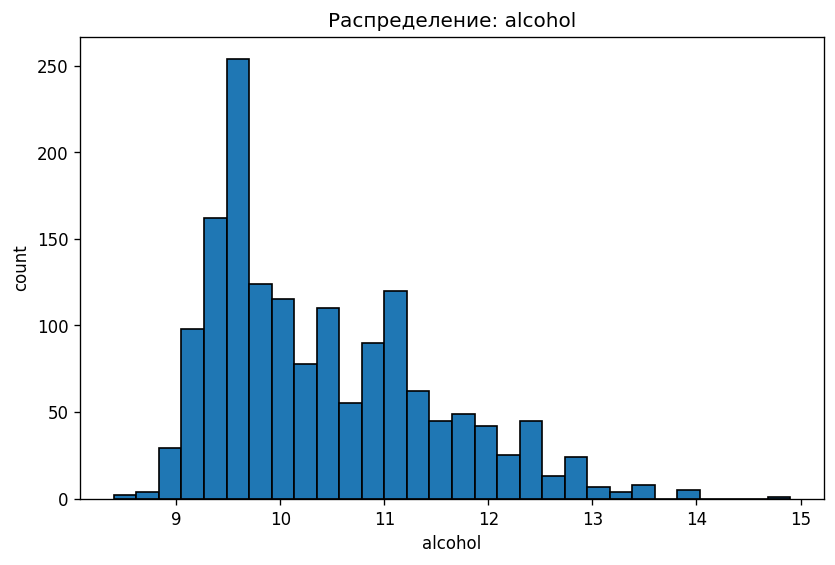

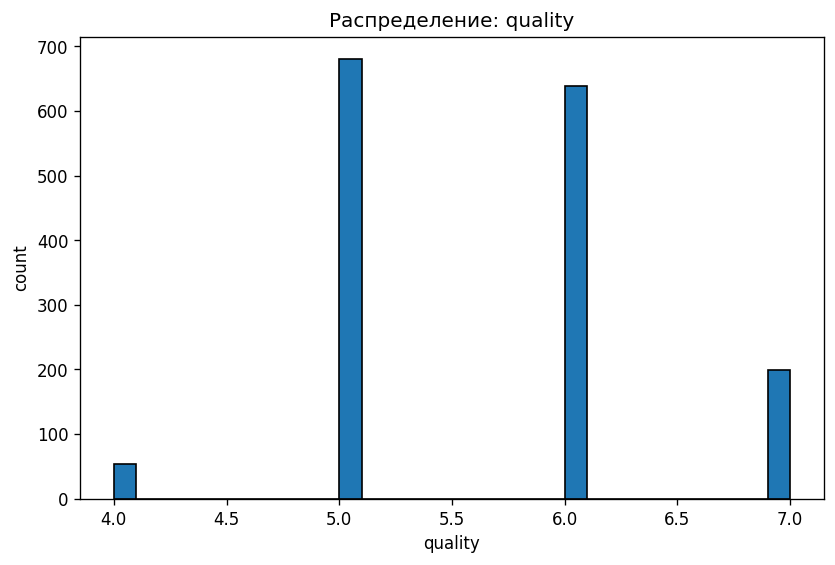

In [9]:

# === Этап 4.1: Распределения по каждому признаку (12 признаков) ===
# В Wine Quality (red) числовых признаков 11 + столбец quality = 12 признаков итого.
num_cols = [c for c in df_clean.columns if c not in ("is_good",)]
for col in num_cols:
    plt.figure()
    # Автоматический выбор бинов
    plt.hist(df_clean[col].dropna().values, bins=30, edgecolor="black")
    plt.title(f"Распределение: {col}")
    plt.xlabel(col); plt.ylabel("count")
    plt.show()


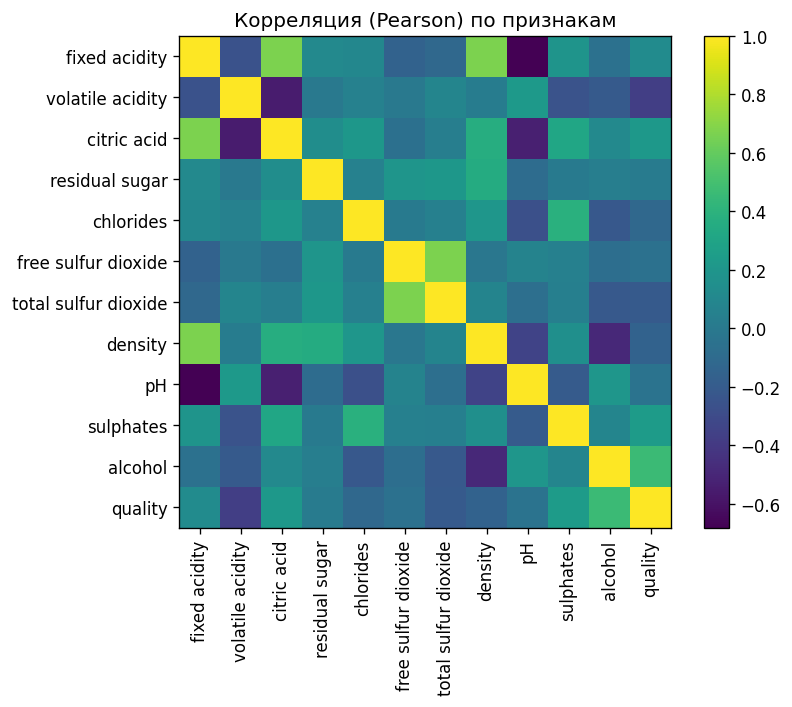

In [10]:

# === Этап 4.2: Матрица корреляции между признаками ===
corr = df_clean[num_cols].corr(method="pearson")
plt.figure(figsize=(8,6))
im = plt.imshow(corr.values, interpolation="nearest")
plt.title("Корреляция (Pearson) по признакам")
plt.xticks(ticks=range(len(num_cols)), labels=num_cols, rotation=90)
plt.yticks(ticks=range(len(num_cols)), labels=num_cols)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


In [11]:

# === Этап 5: Вывод числовых ответов (после удаления выбросов) ===
answers = {}

# 1) Количество выбросов по quality (до удаления)
answers["n_outliers_quality"] = n_outliers

# 2) Баланс классов после удаления выбросов
answers["class_balance_after"] = df_clean["is_good"].value_counts().to_dict()

# 3) Медианы по признакам (после удаления выбросов)
answers["medians_after"] = medians["median"].to_dict()

# 4) Размер данных после очистки
answers["shape_after"] = df_clean.shape

# 5) Краткая сводка корреляций (топ-5 по абсолютному значению, исключая авто-корреляцию)
corr_abs = corr.abs().where(~np.eye(corr.shape[0], dtype=bool))
top_pairs = (
    corr_abs.stack()
            .sort_values(ascending=False)
            .dropna()
            .head(5)
)
answers["top_corr_pairs"] = {f"{i}-{j}": float(v) for (i,j), v in top_pairs.items()}

print("=== ОТВЕТЫ ДЛЯ ТЕСТА (копируйте значения из этого словаря) ===")
for k, v in answers.items():
    print(f"{k}: {v}")


=== ОТВЕТЫ ДЛЯ ТЕСТА (копируйте значения из этого словаря) ===
n_outliers_quality: 28
class_balance_after: {1: 837, 0: 734}
medians_after: {'alcohol': 10.1, 'chlorides': 0.079, 'citric acid': 0.26, 'density': 0.99675, 'fixed acidity': 7.9, 'free sulfur dioxide': 14.0, 'pH': 3.31, 'quality': 6.0, 'residual sugar': 2.2, 'sulphates': 0.62, 'total sulfur dioxide': 38.0, 'volatile acidity': 0.52}
shape_after: (1571, 13)
top_corr_pairs: {'pH-fixed acidity': 0.6816905150953418, 'fixed acidity-pH': 0.6816905150953418, 'fixed acidity-density': 0.6684463034364477, 'density-fixed acidity': 0.6684463034364477, 'citric acid-fixed acidity': 0.6680545171777347}


In [12]:

# (Опционально) Сохранить очищенный датасет для повторного использования
df_clean.to_csv("winequality-red-clean.csv", index=False)
print("Файл сохранён:", os.path.abspath("winequality-red-clean.csv"))


Файл сохранён: /content/winequality-red-clean.csv
